In [1]:
%%shell
rm -rf *
wget -O image1.jpg -q https://user-images.githubusercontent.com/49367723/167856051-9f3c2b7f-263b-4bfb-9486-62584891483f.jpg
wget -O image2.jpg -q https://user-images.githubusercontent.com/49367723/167856011-de4b38bd-36a3-4e4c-9f57-a3ec25b2c2f5.jpg

In [2]:
%%shell

wget -O models.zip -q https://github.com/YoungY620/neu-lung2022/releases/download/v0.4/models.zip
unzip -o -q models.zip -d models

# 绘制面积比蒙版图

In [3]:
import cv2 as cv
import numpy as np



def _remove_unnecessary_region(mask):
    mask = np.array(mask, copy=True)
    n, labels = cv.connectedComponents(mask[:,:,0])
    edge_unique = np.unique(labels[[0, -1], :][:, [0, -1]])[1:]
    for i in edge_unique:
        mask[np.where(labels == i)] = 0
    return mask


def _get_area(img, hist, remove_unnecessary=False):
    hsvt = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    dst = cv.calcBackProject([hsvt], [0, 1], hist, [0, 180, 0, 256], 1)

    # Now convolute with circular disc
    disc = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
    cv.filter2D(dst, -1, disc, dst)

    # threshold and binary AND
    _, thresh = cv.threshold(dst, 0, 255, 0)
    thresh = cv.merge((thresh, thresh, thresh))
    if remove_unnecessary:
        thresh = _remove_unnecessary_region(thresh)
    return np.uint8(thresh[:,:,:])


def _color_ratio_feature(im, n_hist, c_hist, b_hist, rm_unnecessary=False):
    '''rm_unnecessary: 不考虑与边缘联通的空白区域.'''
    n_area = _get_area(np.array(im.copy()), n_hist)
    c_area = _get_area(np.array(im.copy()), c_hist)
    b_area = _get_area(np.array(im.copy()), b_hist, rm_unnecessary)
    # if c_area == 0: c_area = 1
    # return np.array([n_area/c_area, b_area/c_area])
    return n_area, c_area, b_area

In [4]:
import numpy as np

background_hist = np.load('models/background.npy')
cytoplasm_hist = np.load('models/cytoplasm.npy')
nucleus_hist = np.load('models/nucleus.npy')

In [5]:
from PIL import Image
import cv2 as cv

np_img = cv.imread("image1.jpg")
n_area, c_area, b_area = _color_ratio_feature(np_img, nucleus_hist, cytoplasm_hist, background_hist)

In [6]:
import cv2

cv2.imwrite("n_area.jpg", n_area)
cv2.imwrite("c_area.jpg", c_area)
cv2.imwrite("b_area.jpg", b_area)

True

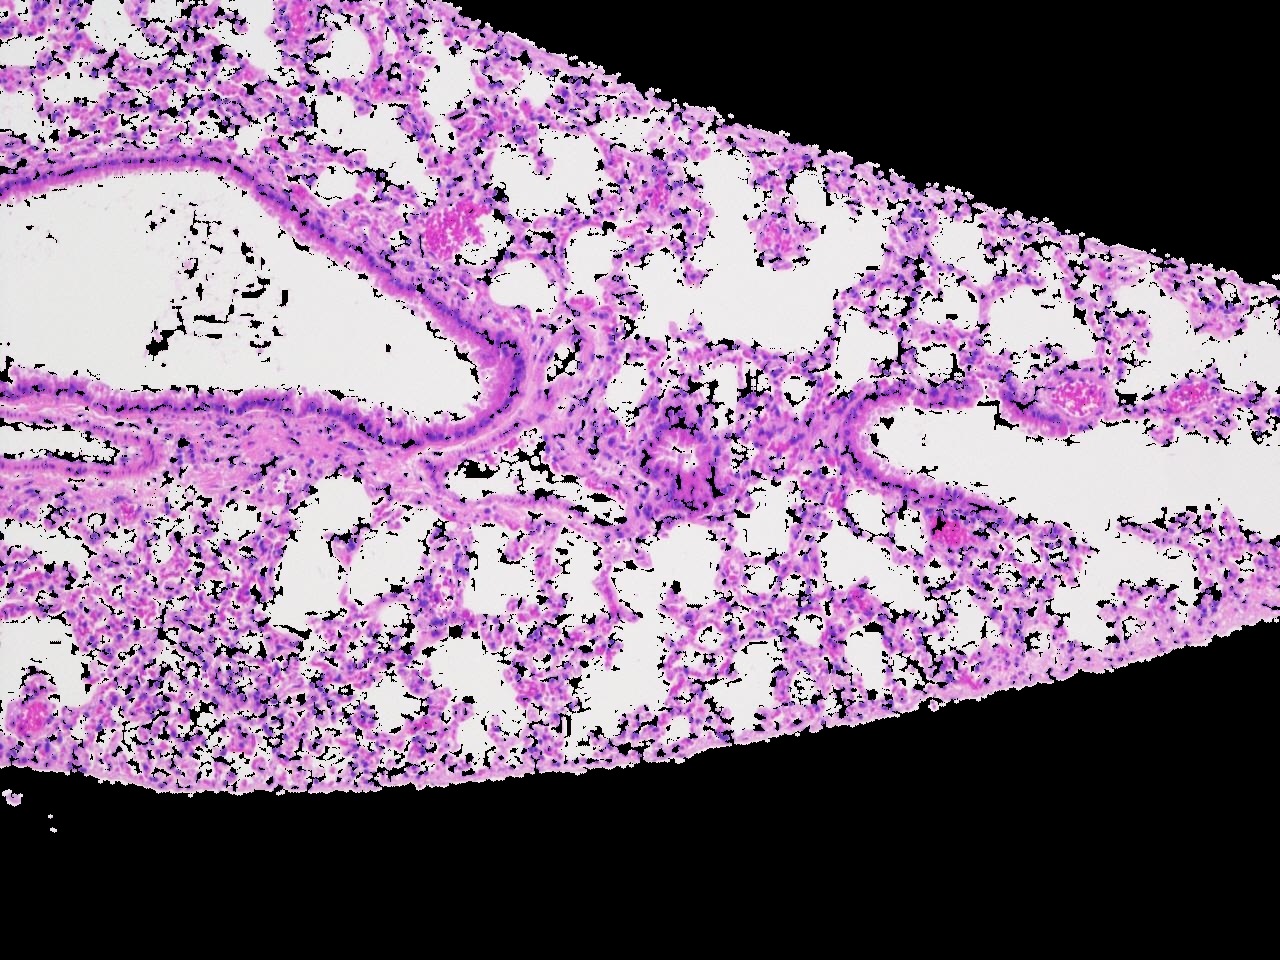

True

In [7]:
import cv2 as cv

np_img = cv.imread("image2.jpg")
n_area, c_area, b_area = _color_ratio_feature(np_img, nucleus_hist, cytoplasm_hist, background_hist, rm_unnecessary=True)
_, merged_area = cv.threshold(n_area+c_area+b_area, 0, 255, 0)


# alpha 为第一张图片的透明度
alpha = 1
# beta 为第二张图片的透明度
beta = 1
gamma = 0
# cv2.addWeighted 将原始图片与 mask 融合
# mask_img = cv2.addWeighted(np_img, alpha, colored_mask, beta, gamma)
mask_img = cv2.copyTo(np_img, merged_area)

try:
  cv.imshow(mask_img)
except:
  from google.colab.patches import cv2_imshow
  cv2_imshow(mask_img)
cv2.imwrite("mask_img.jpg", mask_img)

# 绘制小波能量图

In [8]:
import pywt


def _wavelet_trans_features(grey_np_img, n_level=3):
    re = []  # 第n层所有节点的分解系数
    grey_np_img = np.array(grey_np_img, copy=True)
    wp = pywt.WaveletPacket2D(
        data=grey_np_img, wavelet='db1', mode='symmetric', maxlevel=n_level)
    # for p in [n.path for nodes in wp.get_level(n_level, 'freq') for n in nodes]:
    #     re = np.append(re, np.array(
    #         [float(pow(np.linalg.norm(wp[p].data, ord=None), 2))]), axis=0)
    return wp

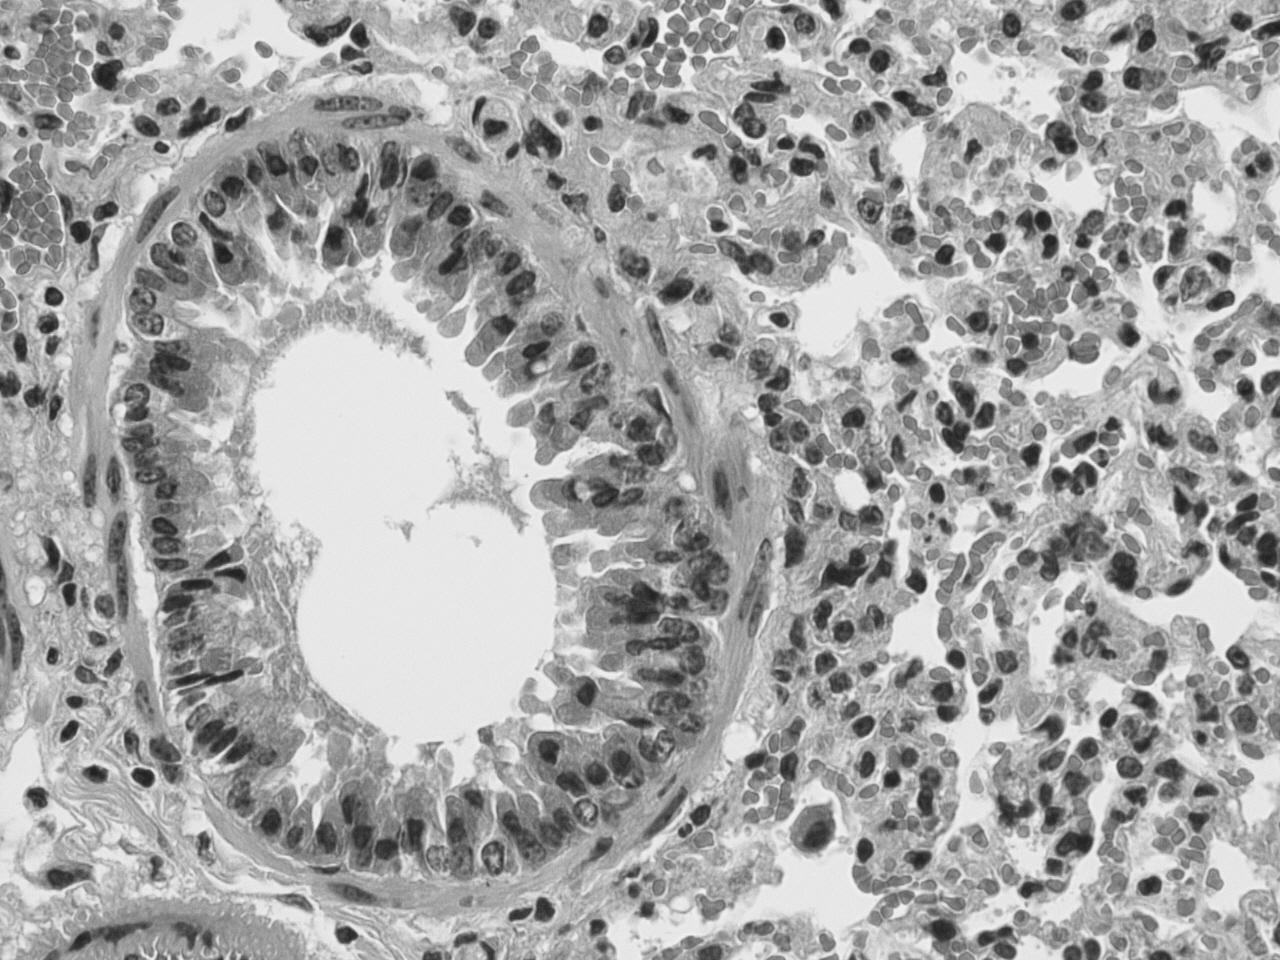

True

In [9]:
import numpy as np
import cv2 as cv

im = cv.imread("image1.jpg", cv.COLOR_BGR2GRAY)
grey_np_im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
try:
  cv.imshow(grey_np_im)
except:
  from google.colab.patches import cv2_imshow
  cv2_imshow(grey_np_im)
cv2.imwrite("grey.jpg", grey_np_im)

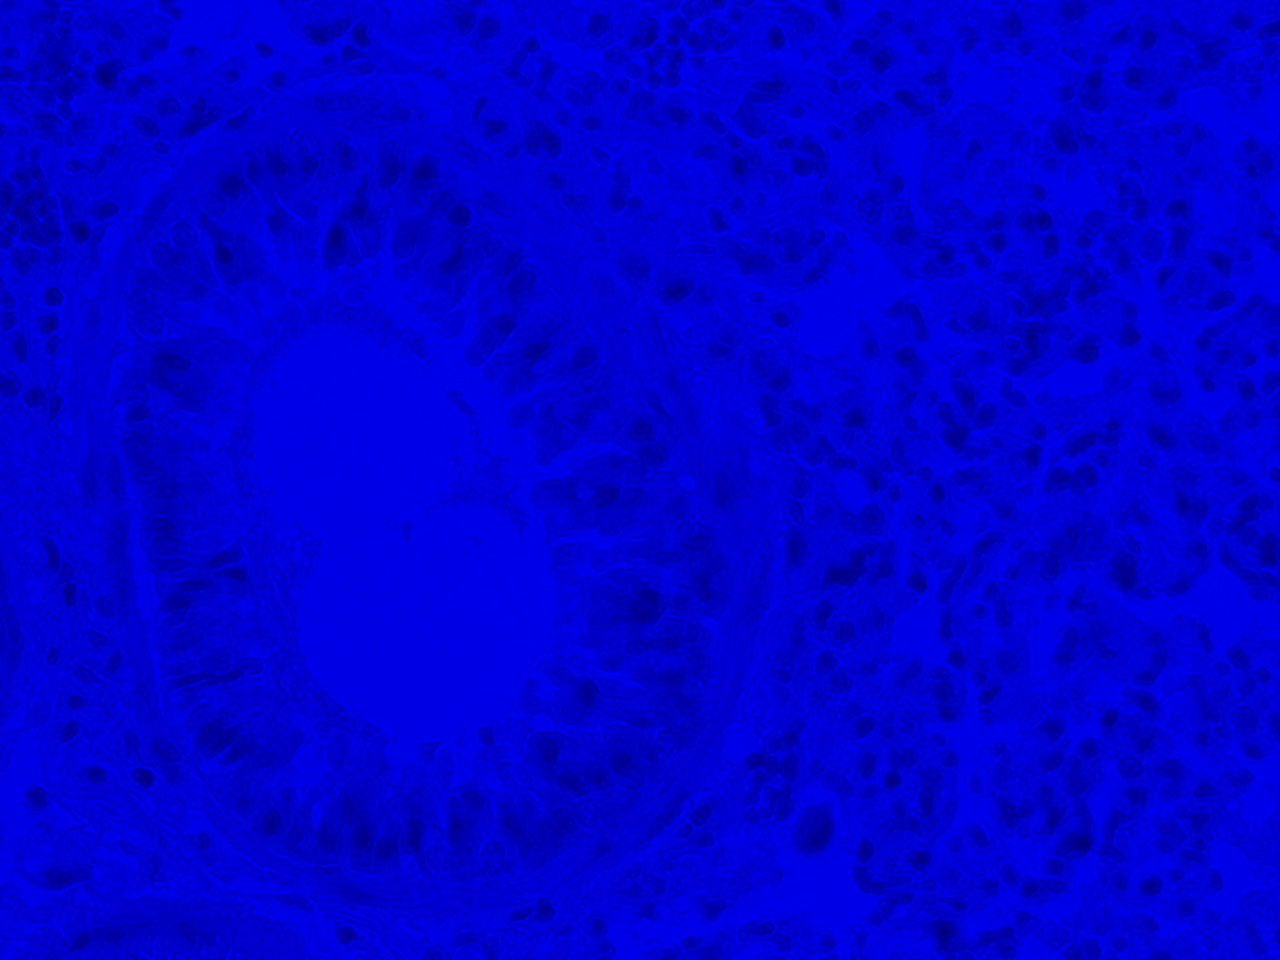

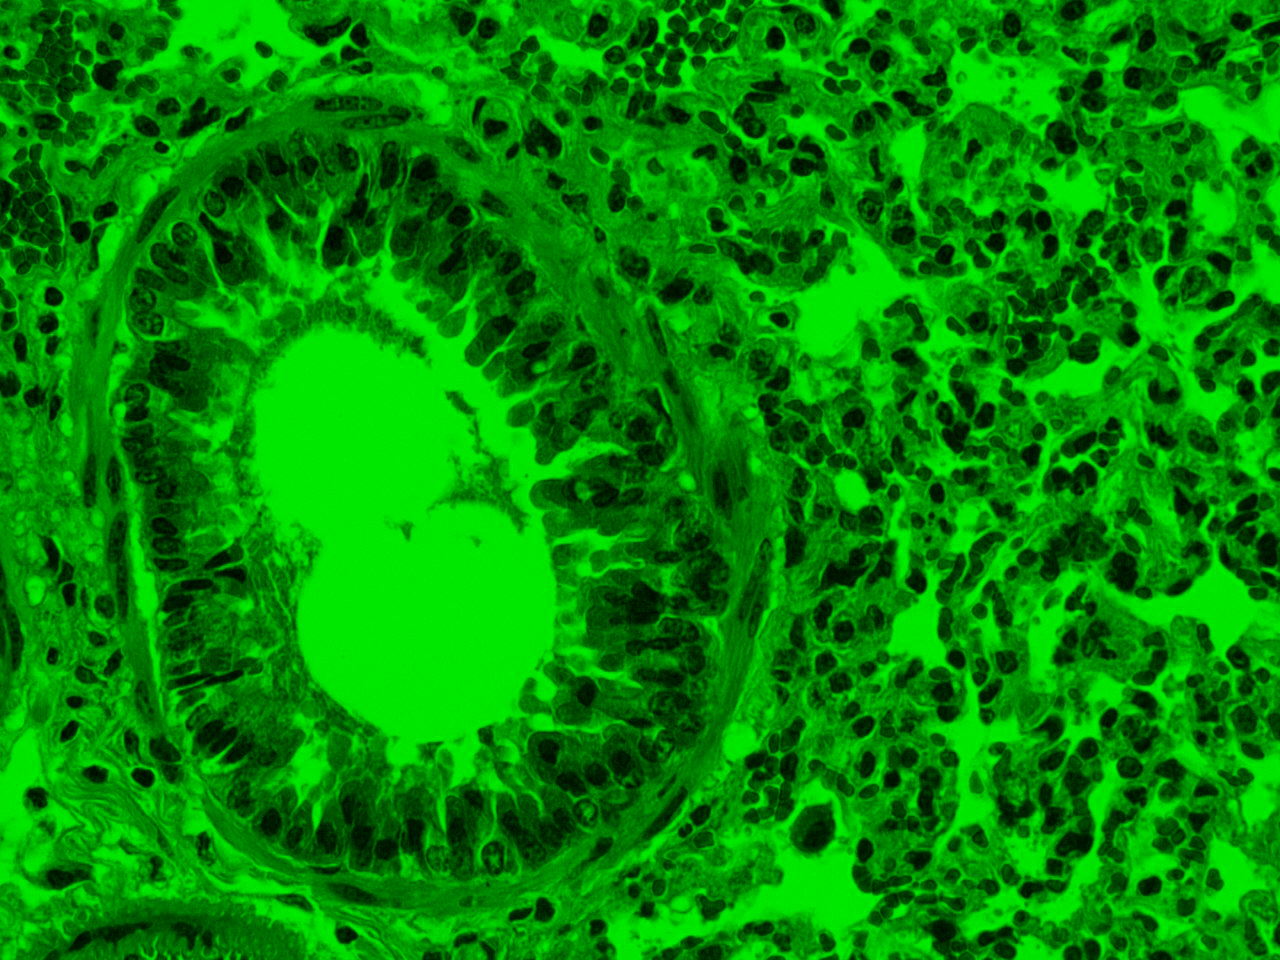

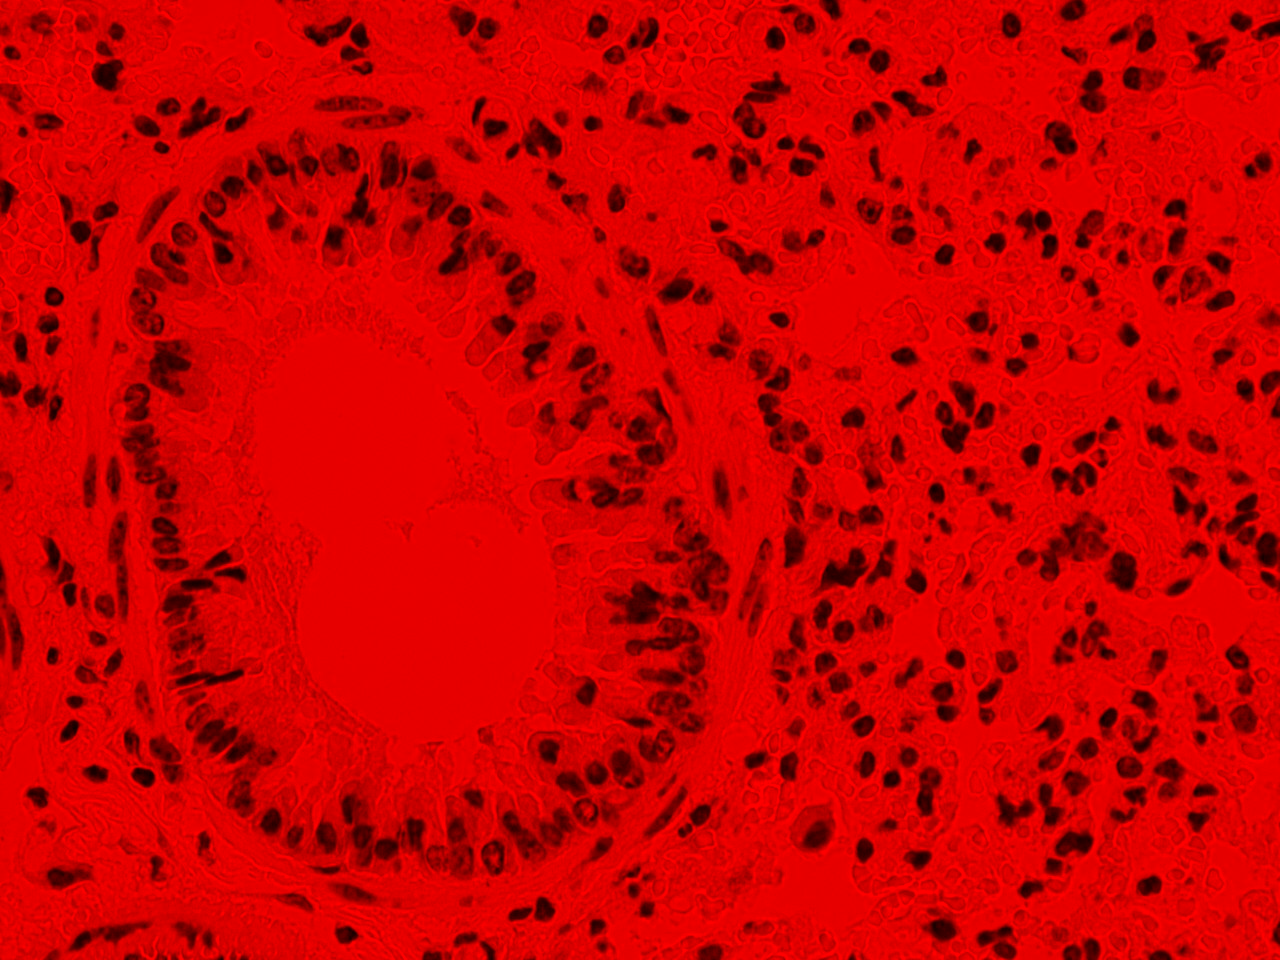

In [10]:

import cv2
import  matplotlib.pyplot as plt
import  numpy as np
from google.colab.patches import cv2_imshow
 
img = cv2.imread("image1.jpg")
# img = img[0:500,0:2000]
b,g,r = cv2.split(img)
img1 = img.copy()
img1[:,:,2] = 0
img1[:,:,1] = 0
cv2_imshow(img1)
img = cv2.imread("image1.jpg")
# img = img[0:500,0:2000]
b,g,r = cv2.split(img)
img1 = img.copy()
img1[:,:,2] = 0
img1[:,:,0] = 0
cv2_imshow(img1)
img = cv2.imread("image1.jpg")
# img = img[0:500,0:2000]
b,g,r = cv2.split(img)
img1 = img.copy()
img1[:,:,1] = 0
img1[:,:,0] = 0
cv2_imshow(img1)

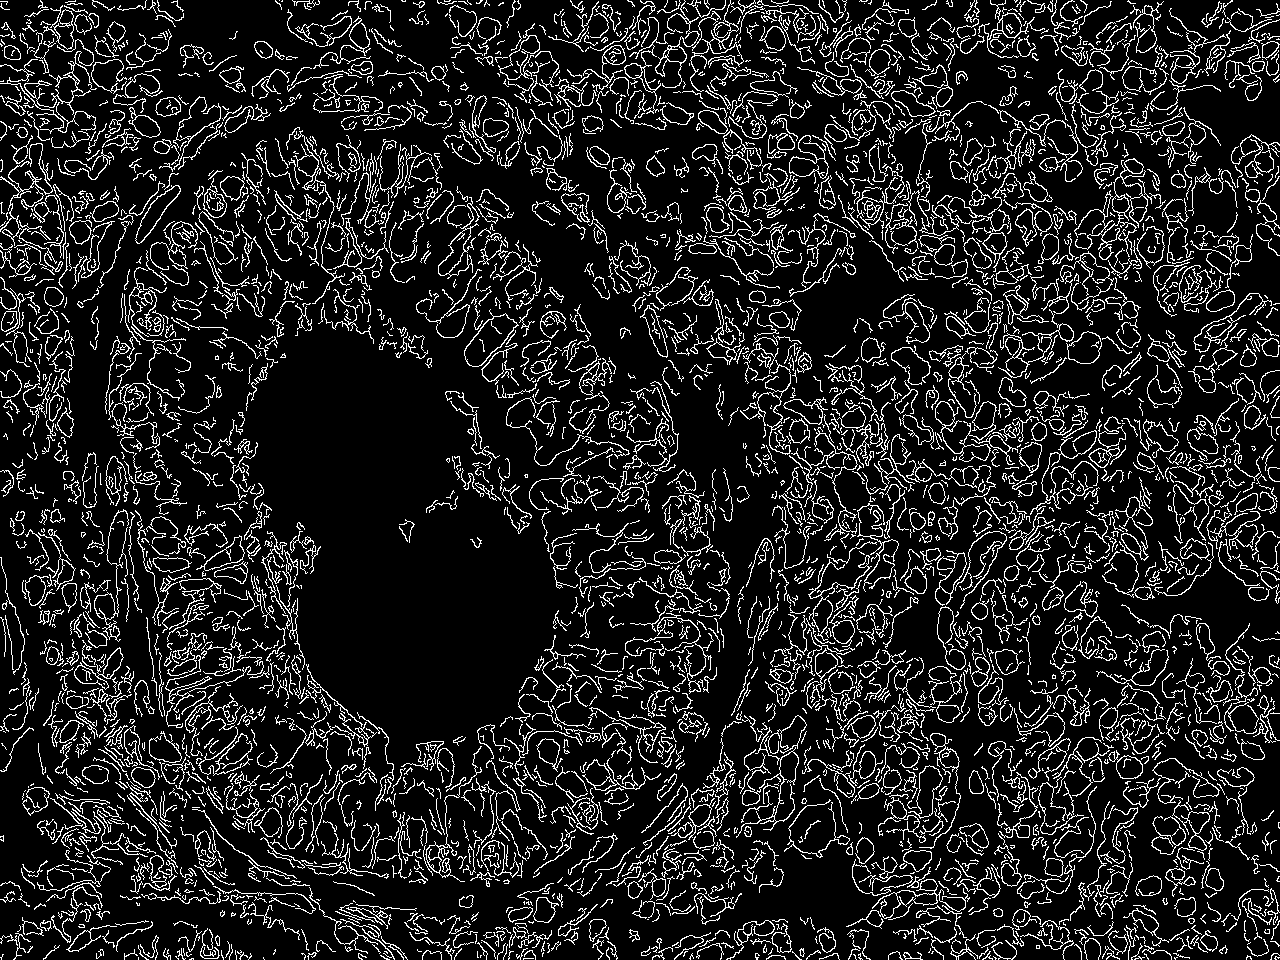

True

In [11]:
import cv2 as cv
import numpy as np
from PIL import Image

img = Image.open("image1.jpg")
_img = np.array(img.convert('L'))
edge = cv.Canny(_img, 100, 200)[:, :, None]
try:
  cv.imshow(edge)
except:
  from google.colab.patches import cv2_imshow
  cv2_imshow(edge)
cv.imwrite("edge.jpg", edge)

In [12]:
import numpy as np
import torch
from torch import nn
from torchvision.transforms import transforms
from PIL import Image
import cv2 as cv

np.random.seed(0)

class GaussianBlur(object):
  """
  blur a single image on CPU
  """
  def __init__(self, kernel_size):
    radias = kernel_size // 2
    kernel_size = radias * 2 + 1
    self.blur_h = nn.Conv2d(3, 3, kernel_size=(kernel_size, 1),
                            stride=1, padding=0, bias=False, groups=3)
    self.blur_v = nn.Conv2d(3, 3, kernel_size=(1, kernel_size),
                            stride=1, padding=0, bias=False, groups=3)
    self.k = kernel_size
    self.r = radias

    self.blur = nn.Sequential(
        nn.ReflectionPad2d(radias),
        self.blur_h,
        self.blur_v
    )

    self.pil_to_tensor = transforms.ToTensor()
    self.tensor_to_pil = transforms.ToPILImage()

  def __call__(self, img):
    img = self.pil_to_tensor(img).unsqueeze(0)

    sigma = np.random.uniform(0.1, 2.0)
    x = np.arange(-self.r, self.r + 1)
    x = np.exp(-np.power(x, 2) / (2 * sigma * sigma))
    x = x / x.sum()
    x = torch.from_numpy(x).view(1, -1).repeat(3, 1)

    self.blur_h.weight.data.copy_(x.view(3, 1, self.k, 1))
    self.blur_v.weight.data.copy_(x.view(3, 1, 1, self.k))

    with torch.no_grad():
        img = self.blur(img)
        img = img.squeeze()

    img = self.tensor_to_pil(img)

    return img


class AddCannyEdgeLayer(object):
  def __init__(self, threadhold1, threadhold2):
    self.th1 = threadhold1
    self.th2 = threadhold2

  def __call__(self, img: Image):
    _img = np.array(img.convert('L'))
    edge = cv.Canny(_img, 100, 200)[:, :, None]
    # print(img.shape, _img.shape, edge.shape)
    img = np.append(img, edge, axis=-1)
    return img


def get_simclr_pipeline_transform(size=80, s=1, trans=0):
    """Return a set of data augmentation transformations as described in the SimCLR paper."""
    color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)

    trans = [
        transforms.RandomResizedCrop(size=size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([color_jitter], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        GaussianBlur(kernel_size=int(0.1 * size)),
        # AddCannyEdgeLayer(50, 200),
        # transforms.ToTensor()
    ]
    
    data_transforms = transforms.Compose(trans)
    return data_transforms



In [13]:
%%shell

wget -O image3.jpg -q https://user-images.githubusercontent.com/49367723/168034987-a422e6a8-a3cb-4745-98ce-8dbba8e411d5.jpg
wget -O image4.jpg -q https://user-images.githubusercontent.com/49367723/168035053-ed3f942b-937b-4fa5-9312-d0535f90f291.jpg
wget -O image5.jpg -q https://user-images.githubusercontent.com/49367723/168035084-80cc626d-1bfe-4e30-b89b-ea433581fd4e.jpg

In [14]:
%%shell
rm -rf augmented
mkdir augmented

In [15]:
from PIL import Image

for j in [1, 3, 4, 5]:
  for i in range(5):
    origin_img = Image.open(f"image{j}.jpg")
    my_transforms = get_simclr_pipeline_transform(640)
    my_transforms(origin_img).save(f"augmented/augmented-{j}-{i}.jpg")


In [16]:
%%shell

zip -rr augmented.zip augmented

  adding: augmented/ (stored 0%)
  adding: augmented/augmented-5-3.jpg (deflated 4%)
  adding: augmented/augmented-4-4.jpg (deflated 1%)
  adding: augmented/augmented-1-0.jpg (deflated 0%)
  adding: augmented/augmented-4-2.jpg (deflated 4%)
  adding: augmented/augmented-3-1.jpg (deflated 0%)
  adding: augmented/augmented-4-1.jpg (deflated 1%)
  adding: augmented/augmented-3-0.jpg (deflated 1%)
  adding: augmented/augmented-4-0.jpg (deflated 1%)
  adding: augmented/augmented-1-1.jpg (deflated 2%)
  adding: augmented/augmented-4-3.jpg (deflated 1%)
  adding: augmented/augmented-1-2.jpg (deflated 10%)
  adding: augmented/augmented-5-1.jpg (deflated 1%)
  adding: augmented/augmented-3-4.jpg (deflated 0%)
  adding: augmented/augmented-3-2.jpg (deflated 1%)
  adding: augmented/augmented-5-0.jpg (deflated 0%)
  adding: augmented/augmented-3-3.jpg (deflated 1%)
  adding: augmented/augmented-1-4.jpg (deflated 1%)
  adding: augmented/augmented-1-3.jpg (deflated 3%)
  adding: augmented/augmented-

In [17]:
import torch 

batch_size = 5
n_views = 2

labels = torch.cat([torch.arange(batch_size) for i in range(n_views)], dim=0)
labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
labels.shape

torch.Size([10, 10])

In [18]:
import torch

a = torch.ones((2,3))
b = torch.zeros((2,3))
torch.cat([a, b], dim=1)

tensor([[1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.]])

# 特征的相关度分析

In [19]:
%%shell
pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import cv2 as cv
import numpy as np
import pywt
from skimage.feature import greycomatrix, greycoprops
import torch


def _abstract_features(tensor_image, model, device):
    model.to(device)
    if device == torch.device("cpu"):
        tensor_image = tensor_image.cpu()
    else:
        tensor_image = tensor_image.cuda()
    return np.array(model(tensor_image).cpu().detach()).flatten()


def _comatrix_features(grey_np_img):
    ftrs = []
    grey_np_img = np.array(grey_np_img, copy=True)
    compress_gray = np.digitize(grey_np_img, np.linspace(0, 255, 64))
    comatrix = greycomatrix(compress_gray, np.linspace(10, 20, num=4),
                            [0, np.pi / 4, np.pi / 2, np.pi * 3 / 4],
                            256, symmetric=True, normed=True)
    for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']:
        ftrs.append(greycoprops(comatrix, prop).flatten())

    return np.array(ftrs).flatten()


def _remove_unnecessary_region(mask):
    mask = np.array(mask, copy=True)
    n, labels = cv.connectedComponents(mask[:,:,0])
    edge_unique = np.unique(labels[[0, -1], :][:, [0, -1]])[1:]
    for i in edge_unique:
        mask[np.where(labels == i)] = 0
    return mask


def _get_area(img, hist, remove_unnecessary=False):
    hsvt = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    dst = cv.calcBackProject([hsvt], [0, 1], hist, [0, 180, 0, 256], 1)

    # Now convolute with circular disc
    disc = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
    cv.filter2D(dst, -1, disc, dst)

    # threshold and binary AND
    _, thresh = cv.threshold(dst, 0, 255, 0)
    thresh = cv.merge((thresh, thresh, thresh))
    if remove_unnecessary:
        thresh = _remove_unnecessary_region(thresh)
    return np.where(thresh[:, :, 0])[0].shape[0]


def _color_ratio_feature(im, n_hist, c_hist, b_hist, rm_unnecessary=False):
    '''rm_unnecessary: Blank areas connected to edges are not considered.'''
    n_area = _get_area(np.array(im.copy()), n_hist)
    c_area = _get_area(np.array(im.copy()), c_hist)
    b_area = _get_area(np.array(im.copy()), b_hist, rm_unnecessary)
    if c_area == 0: c_area = 1
    return np.array([n_area/c_area, b_area/c_area])


def get_flatten_rating_feature(im, index, transforms, encoder_model, device, n_hist, c_hist, b_hist):
    # print(f"{index} started.")
    im = im.convert('RGB')
    grey_np_im = np.array(im.copy().convert('L'))
    tensor_im = transforms(im.copy()).unsqueeze(0).to(device)
    ftr = []

    # ftr = np.append(ftr, _abstract_features(tensor_im, encoder_model, device)) # 小秘密: 由于数据量小, 其实加上抽象特征效果更差
    ftr = np.zeros((64,))
    ftr = np.append(ftr, _comatrix_features(grey_np_im))
    ftr = np.append(ftr, _color_ratio_feature(im, n_hist, c_hist, b_hist, rm_unnecessary=(index=='E')))
    # print(f"{index} completed.")
    return ftr

In [21]:
import numpy as np
import torch
from torch import nn
from torchvision.transforms import transforms
from PIL import Image
import cv2 as cv

np.random.seed(0)


class AddCannyEdgeLayer(object):
  def __init__(self, threadhold1, threadhold2):
    self.th1 = threadhold1
    self.th2 = threadhold2

  def __call__(self, img: Image):
    _img = np.array(img.convert('L'))
    edge = cv.Canny(_img, 100, 200)[:, :, None]
    # print(img.shape, _img.shape, edge.shape)
    img = np.append(img, edge, axis=-1)
    return img

def get_simclr_encoding_transform(size=80):
    trans = [
        transforms.Resize(size),
        AddCannyEdgeLayer(50, 200), 
        transforms.ToTensor()
    ]
    # converts the image, a PIL image, into a PyTorch Tensor
    return transforms.Compose(trans)


In [22]:
import torch.nn as nn
import torchvision.models as models

class ResNetSimCLR(nn.Module):

    def __init__(self, out_dim, base_model="resnet18"):
        super(ResNetSimCLR, self).__init__()
        self.resnet_dict = {"resnet18": models.resnet18(pretrained=False, num_classes=out_dim)}

        self.backbone = self._get_basemodel(base_model)
        dim_mlp = self.backbone.fc.in_features

        # add mlp projection head
        self.backbone.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.backbone.fc)
        self.backbone = nn.Sequential(
            nn.Conv2d(4, 3, kernel_size=1),
            self.backbone
        )

    def _get_basemodel(self, model_name):
        try:
            model = self.resnet_dict[model_name]
        except KeyError:
            raise NotImplementedError(
                "Invalid backbone architecture. Check the config file and pass one of: resnet18 or resnet50")
        else:
            return model

    def forward(self, x):
        return self.backbone(x)

## 准备 带标签的 bounding box 数据

In [23]:
%%shell
wget -O data.zip -q https://github.com/YoungY620/neu-lung2022/releases/download/v0.4/data.zip
unzip -oq data.zip -d data

In [24]:
import os
import pandas as pd


def get_rating_data(index):
    data_dir = "./data/images"
    if index in ['a', 'b', 'c']:
        df = pd.read_csv("./data/bronchus.csv")
    elif index in ['d']:
        df = pd.read_csv("./data/vessel.csv")
    else:
        df = pd.read_csv("./data/overall.csv")
    pil_images, ratings = [], []
    assert index in ['a', 'b', 'c', 'd', 'e'] and index in df.columns
    df = df.dropna(subset=[index])
    filename = None
    img = None
    for i, row in df.iterrows():
        if row[index] == None: continue
        if row['file_name'] != filename:
            img = Image.open(os.path.join(
                data_dir, row['file_name'])).convert("RGB")
        ratings.append(row[index])
        if index == 'e':
            pil_images.append(img)
        else:
            pil_images.append(img.crop((row['xmin'], row['ymin'], row['xmax'], row['ymax'])))
 
    return pil_images, ratings


In [25]:
import pandas as pd

indexes = ['d','a','b','c','e']
model = ResNetSimCLR(out_dim=64)
checkpoint = torch.load("./models/simclr_encoder.pth.tar", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['state_dict'])
background_hist = np.load('models/background.npy')
cytoplasm_hist = np.load('models/cytoplasm.npy')
nucleus_hist = np.load('models/nucleus.npy')

dfs = {}

for ind in indexes[:]:
  ftr_names = []
  # ftr_names = [f"{i}" for i in range(64)]
  for basename in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']:
    for d in np.linspace(10, 20, num=4):
      for a in [0, np.pi / 4, np.pi / 2, np.pi * 3 / 4]:
        ftr_names.append(f"{d:.2f}st-{a/np.pi*180:.0f}de-{basename}")
  ftr_names = ftr_names + ['nucleus-c', "background-c", ind]
  ftr_dict = {}
  for name in ftr_names:
    ftr_dict[name] = []
  trans = get_simclr_encoding_transform(size=1280 if ind == 'e' else 80)
  X_, Y = get_rating_data(ind)
  for im, rate in zip(X_,Y):
    ftr = get_flatten_rating_feature(im, ind, trans, model, torch.device('cpu'), nucleus_hist, cytoplasm_hist, background_hist)
    ftr = ftr[64:]
    # print(len(ftr))
    for ii,ff in enumerate(ftr):
      ftr_dict[ftr_names[ii]].append(ff)
    ftr_dict[ind].append(rate)
  dfs[ind] = pd.DataFrame(ftr_dict)
dfs['d']

10.00st-0de-contrast  10.00st-45de-contrast  10.00st-90de-contrast  \
0              104.528843             108.095613             106.563296   
1              119.862004             109.210645             106.185910   
2              133.314938             125.280719             116.845827   
3              117.199908             126.840250             128.402329   
4               66.979871              67.809240              63.859181   
..                    ...                    ...                    ...   
127            118.367325             127.829552             131.682001   
128            115.808389             116.455253             114.081762   
129            130.742754             124.490004             116.432677   
130            103.913073             118.016925             116.298426   
131            121.269043             121.318729             129.692552   

     10.00st-135de-contrast  13.33st-0de-contrast  13.33st-45de-contrast  \
0                103.199033            114.544818             117.678226   
1                121.601066            136.601778             122.645479   
2                120.220787            150.959559             136.187263   
3                121.860813            123.334698             141.275977   
4                 68.332481             67.614742              69.028957   
..                      ...                   ...                    ...   
127              117.517015            116.823123             126.933013   
128              111.955899            122.677771             123.251186   
129              127.845050            140.766135             136.486739   
130              104.198690            114.885489             131.851355   
131              130.820989            130.924923             130.436882   

     13.33st-90de-contrast  13.33st-135de-contrast  16.67st-0de-contrast  \
0               119.815078              112.307672            118.132958   
1               119.971391              137.926849            155.585001   
2               128.733910              129.912038            165.593501   
3               140.014958              135.181260            135.055173   
4                64.869378               69.699625             70.076494   
..                     ...                     ...                   ...   
127             138.175061              125.617308            128.781779   
128             123.160139              122.391191            129.455880   
129             125.405552              139.073957            152.923962   
130             128.227452              112.518227            129.091746   
131             137.834942              139.314972            137.851580   

     16.67st-45de-contrast  ...  16.67st-45de-ASM  16.67st-90de-ASM  \
0               128.572779  ...          0.002806          0.002714   
1               138.665911  ...          0.023976          0.021681   
2               145.373514  ...          0.005005          0.009191   
3               157.674673  ...          0.004306          0.003160   
4                72.566387  ...          0.003241          0.003495   
..                     ...  ...               ...               ...   
127             146.457706  ...          0.001620          0.001664   
128             132.182777  ...          0.001867          0.001950   
129             149.674197  ...          0.022587          0.021307   
130             147.416975  ...          0.011540          0.012245   
131             138.078845  ...          0.005751          0.004857   

     16.67st-135de-ASM  20.00st-0de-ASM  20.00st-45de-ASM  20.00st-90de-ASM  \
0             0.003036         0.003954          0.002463          0.002379   
1             0.020690         0.018871          0.021866          0.019624   
2             0.004910         0.002644          0.004098          0.007802   
3             0.004032         0.005840          0.003840          0.002875   
4             0.003319        

In [26]:
names = []
for basename in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']:
  for d in np.linspace(10, 20, num=4)[0:3:2]:
    for a in [0, np.pi / 4, np.pi / 2, np.pi * 3 / 4][0:3:2]:
      names.append(f"{d:.2f}st-{a/np.pi*180:.0f}de-{basename}")
names = names + ['nucleus-c', "background-c", 'd']
dfs['d'][names].corr()[['d']]

d
10.00st-0de-contrast       -0.322164
10.00st-90de-contrast      -0.290235
16.67st-0de-contrast       -0.361280
16.67st-90de-contrast      -0.303098
10.00st-0de-dissimilarity  -0.240492
10.00st-90de-dissimilarity -0.210276
16.67st-0de-dissimilarity  -0.311351
16.67st-90de-dissimilarity -0.256138
10.00st-0de-homogeneity    -0.281160
10.00st-90de-homogeneity   -0.300154
16.67st-0de-homogeneity    -0.228638
16.67st-90de-homogeneity   -0.257976
10.00st-0de-energy         -0.352481
10.00st-90de-energy        -0.358655
16.67st-0de-energy         -0.333942
16.67st-90de-energy        -0.345229
10.00st-0de-correlation    -0.162472
10.00st-90de-correlation   -0.198570
16.67st-0de-correlation    -0.020840
16.67st-90de-correlation   -0.089683
10.00st-0de-ASM            -0.334260
10.00st-90de-ASM           -0.341699
16.67st-0de-ASM            -0.318535
16.67st-90de-ASM           -0.331114
nucleus-c                   0.032101
background-c               -0.414952
d                           1.000000

In [27]:
import pandas as pd

all_corr_df = pd.DataFrame()

names = []
for basename in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']:
  for d in np.linspace(10, 20, num=4)[0:3:2]:
    for a in [0, np.pi / 4, np.pi / 2, np.pi * 3 / 4][0:3:2]:
      names.append(f"{d:.2f}st-{a/np.pi*180:.0f}de-{basename}")
names = names + ['nucleus-c', "background-c"]
print(dfs.keys())
for ind in indexes:
  all_corr_df = pd.concat([all_corr_df,dfs[ind]\
                           [names+[ind]]\
                           .corr().loc[names, [ind]]], axis=1)

all_corr_df[:10]

dict_keys(['d', 'a', 'b', 'c', 'e'])


d         a         b         c         e
10.00st-0de-contrast       -0.322164 -0.273818 -0.326865 -0.136457 -0.113863
10.00st-90de-contrast      -0.290235 -0.260438 -0.286169 -0.119057 -0.120608
16.67st-0de-contrast       -0.361280 -0.358777 -0.400921 -0.233319 -0.156219
16.67st-90de-contrast      -0.303098 -0.259183 -0.298592 -0.200216 -0.154556
10.00st-0de-dissimilarity  -0.240492 -0.156083 -0.166040  0.090475  0.208039
10.00st-90de-dissimilarity -0.210276 -0.146930 -0.131253  0.108193  0.213820
16.67st-0de-dissimilarity  -0.311351 -0.259360 -0.266957 -0.048212  0.108215
16.67st-90de-dissimilarity -0.256138 -0.174643 -0.181992 -0.015536  0.120569
10.00st-0de-homogeneity    -0.281160 -0.298230 -0.293290 -0.411747 -0.760367
10.00st-90de-homogeneity   -0.300154 -0.298951 -0.300371 -0.406879 -0.765039

[Text(0, 0.5, 'd'),
 Text(0, 1.5, 'a'),
 Text(0, 2.5, 'b'),
 Text(0, 3.5, 'c'),
 Text(0, 4.5, 'e')]

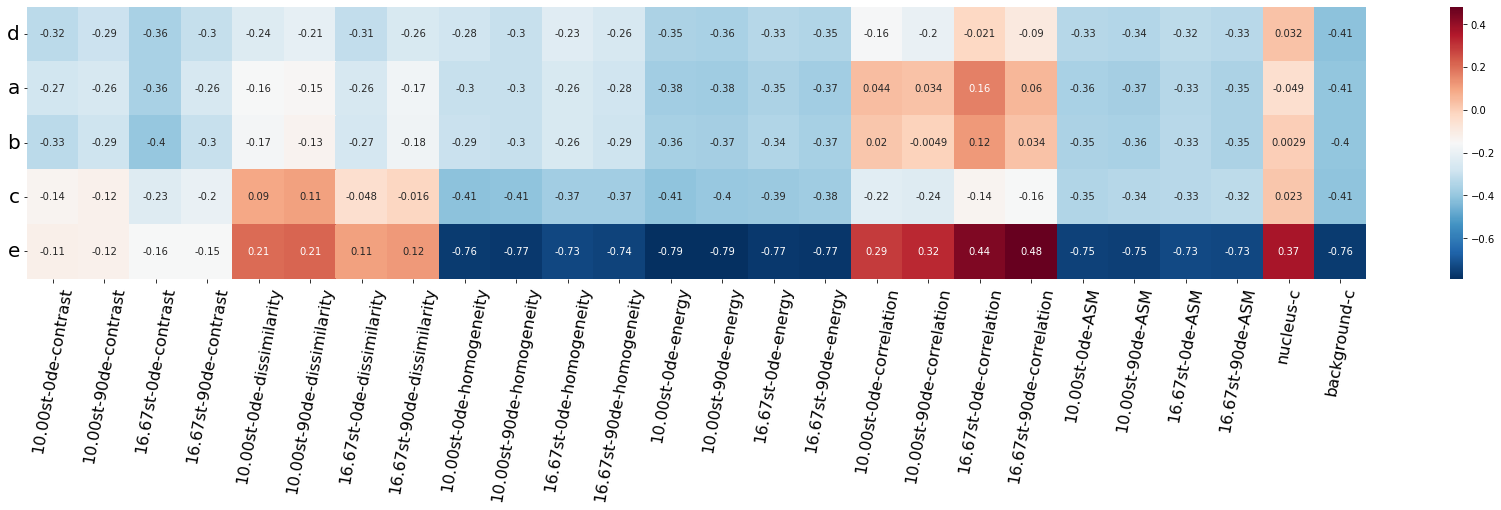

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize = (30,5))
trans = pd.DataFrame(all_corr_df.values.T, index=all_corr_df.columns, columns=all_corr_df.index)
ax = sns.heatmap(trans, annot=True, cmap="RdBu_r")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 80, fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(),rotation = 0, fontsize=20)

In [29]:
ax.get_figure().savefig('HeatMap-toIndicators.jpg',dpi=300,bbox_inches='tight')

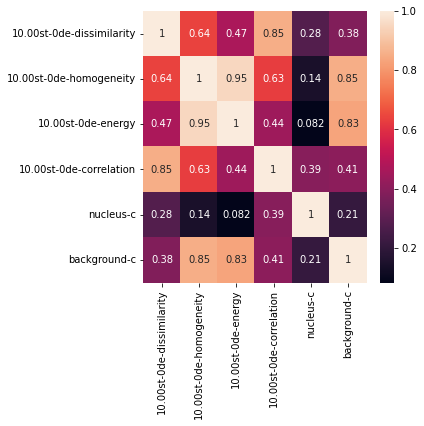

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
names = []
for basename in [
                #  'contrast',
                 'dissimilarity', 
                 'homogeneity', 
                 'energy', 
                 'correlation', 
                #  'ASM'
        ]:
  for d in np.linspace(10, 20, num=4)[:1]:
    for a in [0, np.pi / 4, np.pi / 2, np.pi * 3 / 4][:1]:
      names.append(f"{d:.2f}st-{a/np.pi*180:.0f}de-{basename}")
names = names + ['nucleus-c', "background-c"]
plt.subplots(figsize = (5,5))
self_corr = dfs['a'][names].corr().abs()
trans = pd.DataFrame(self_corr.values.T, index=self_corr.columns, columns=self_corr.index)
ax = sns.heatmap(trans, annot=True)
# ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
# ax.set_yticklabels(ax.get_yticklabels(),rotation = 20)


In [31]:
ax.get_figure().savefig('HeatMap-toSelf.jpg',dpi=300,bbox_inches='tight')

In [32]:
!pip install minepy
import pandas as pd
import matplotlib.pyplot as plt
from minepy import MINE

def MIC_matirx(dataframe, mine):

    data = np.array(dataframe)
    n = len(data[0, :])
    result = np.zeros([n, n])

    for i in range(n):
        for j in range(n):
            mine.compute_score(data[:, i], data[:, j])
            result[i, j] = mine.mic()
            result[j, i] = mine.mic()
    RT = pd.DataFrame(result)
    return RT
def ShowHeatMap(DataFrame):
    colormap = plt.cm.RdBu
    ylabels = DataFrame.columns.values.tolist()
    f, ax = plt.subplots(figsize=(14, 14))
    ax.set_title('GRA HeatMap')
    sns.heatmap(DataFrame.astype(float),
                cmap=colormap,
                ax=ax,
                annot=True,
                yticklabels=ylabels,
                xticklabels=ylabels)
    plt.show()




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 496 kB 9.3 MB/s 
  Created wheel for minepy: filename=minepy-1.2.6-cp37-cp37m-linux_x86_64.whl size=177585 sha256=6b57fc9f920f368ec2c25298a32aa6f75f54006ebbe6ca3d5a619154f48146bc
  Stored in directory: /root/.cache/pip/wheels/81/71/75/403a33428e468a25c93fa7b672d070b304f36642eb699a29e0
Successfully built minepy


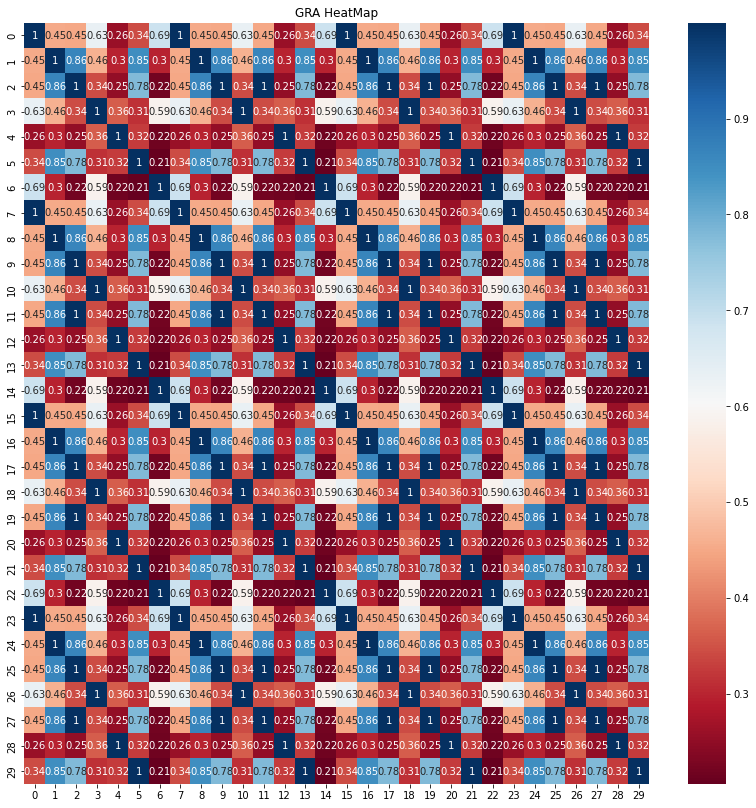

In [38]:
for basename in ['contrast','dissimilarity', 'homogeneity', 'energy','correlation', 'ASM']:
  for d in np.linspace(10, 20, num=4)[:1]:
    for a in [0, np.pi / 4, np.pi / 2, np.pi * 3 / 4][:1]:
      names.append(f"{d:.2f}st-{a/np.pi*180:.0f}de-{basename}")
names = names + ['nucleus-c', "background-c"]

mine = MINE(alpha=0.6, c=15)
data_wine_mic = MIC_matirx(dfs['a'][names], mine)
# plt.subplots(figsize = (5,5))
ShowHeatMap(data_wine_mic)